In [2]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import fmplib as fmp

%matplotlib inline
fmp.documentation_button()

In [3]:
#get audio
snd1 = fmp.load_wav('wav/Twinkle1.wav')

In [4]:
#make stft with hanning window (N=4096, H=1024, zp factor = 4)
#plot stft
N = 4096
H = 1024
fs = 22050
snd_stft = np.abs(fmp.stft(snd1, N, H, zp_factor=4))
snd_stft = np.log10(1+10*snd_stft)

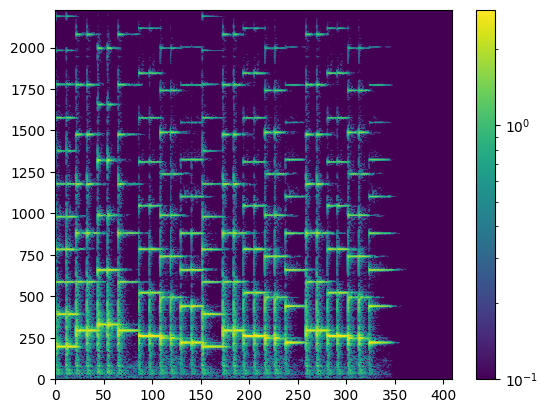

In [5]:
#consider k within k range wanted
k_upper = int(N*12000/fs)
new_stft = snd_stft[:k_upper, :]
fmp.plot_spectrogram(new_stft)

In [6]:
#calculate tonality at k
def tonality(stft):
    return amp_tonality(stft)*peak_tonality(stft, 8)
    pass

def amp_tonality(stft):
    shift_stft = np.pad(stft[:, :-1], ((0, 0), (1, 0)), mode='constant', constant_values=0)
    return abs((abs(stft)-abs(shift_stft))/shift_stft)

def peak_tonality(stft, m):
    pad_stft = np.pad(stft, ((m, m), (0, 0)), mode='constant', constant_values=0)
    return (abs(pad_stft[:len(stft),:])-abs(pad_stft[2*m:,:]))/abs(stft)

T = tonality(new_stft)
#get T threshold
T_peaks = np.array(np.where((T > .7) & (new_stft > .01*np.max(new_stft))))
# print()
print(new_stft[T_peaks[0], T_peaks[1]])

[0.37257254 0.41592023 0.04139009 ... 0.11883148 0.03881231 0.06150069]


C:\Users\my537\AppData\Local\Temp\ipykernel_4556\1371098689.py:8: RuntimeWarning: divide by zero encountered in divide
  return abs((abs(stft)-abs(shift_stft))/shift_stft)


In [7]:
#calculate saliance values of remaining k and do a threshold with max saliance val
sal_stft = snd_stft**.25
def calc_saliance(t_peaks, stft): #make sure to have transposed version
    #calculate saliance for all peaks
    #np where saliance is above s
    vals = stft[t_peaks[0], t_peaks[1]] + stft[2*t_peaks[0], t_peaks[1]] + stft[3*t_peaks[0], t_peaks[1]]
    threshold = .95**25*np.max(vals) #change later?
    return t_peaks.T[vals > threshold]
    pass

saliance_peaks = calc_saliance(T_peaks, sal_stft)
print(len(saliance_peaks))

61115


In [30]:
#making arrays to represent each part of peaks
k_peaks = saliance_peaks[:, 0]
n_peaks = saliance_peaks[:, 1]
x_peaks = new_stft[saliance_peaks[:, 0], saliance_peaks[:, 1]]

E = np.zeros(new_stft.shape)
    
# Process each unique time frame
for n in range(new_stft.shape[1]):
    # Extract peaks for this frame
    peaks_in_frame = saliance_peaks[saliance_peaks[:, 0] == n]
    if len(peaks_in_frame) == 0:
        continue  # No peaks for this frame
    
    k_peaks = peaks_in_frame[:, 0]
    magnitudes = new_stft[k_peaks, n]
    
    # Logarithmic frequency mapping
    # log_k_peaks = np.log10(k_peaks)
    # log_k_range = np.log10(np.arange(kmin, kmax + 1))
    
    # Interpolate in the logarithmic domain
    E_temp = np.interp(np.arange(new_stft.shape[1]), k_peaks, magnitudes)
    
    # Smooth the envelope
    # window_size = max(1, int(alpha))  # Ensure window size is at least 1
    smoothing_filter = np.ones(20) / 20
    E[:, n] = np.convolve(E_temp, smoothing_filter, mode='same')

# k_dense = np.linspace(k_peaks.min(), k_peaks.max(), new_stft.shape[0])  # Dense frequency bins
# n_dense = np.arange(new_stft.shape[1])  # Use unique values along n (no need for densification)
# k_grid, n_grid = np.meshgrid(k_dense, n_dense)
# # print(k_grid.shape, n_grid.shape)
# print(new_stft.shape)
# E_prime = np.zeros_like(k_grid)

# for i, n_val in enumerate(n_dense):
#     # Get the peaks for the current frame n_val
#     mask = n_peaks == n_val
#     k_vals = k_peaks[mask]
#     x_vals = x_peaks[mask]

#     # Sort the peaks for proper interpolation
#     sorted_indices = np.argsort(k_vals)
#     k_vals = k_vals[sorted_indices]
#     x_vals = x_vals[sorted_indices]

#     # Perform linear interpolation using NumPy
#     # print(len(E_prime[i, :]))
#     # print(len(np.interp(k_dense, k_vals, x_vals)))
#     # print(len(k_dense), len(k_vals), len(x_vals))
#     # break
#     E_prime[i, :] = np.interp(k_dense, k_vals, x_vals)

ValueError: could not broadcast input array from shape (409,) into shape (2229,)